The system is given by an SDE:
$$d\theta=(\omega-a\sin\theta)dt+\frac{\sigma}{\cos\theta}dW_t$$
and the correspondent function of $\sin\theta$ is
$$d\sin\theta=\cos\theta(\omega-a\sin\theta)dt+{\sigma}dW_t$$

In [8]:
import numpy as np
import scipy.integrate as ode
import random as rd
import os
import time
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib import gridspec
import sdeint


import use_function as f

def wsin(t,z):
    dzdt=a-w*np.sin(z)
    return dzdt
def drift(x,t):
    return a-w*np.sin(x)
def diffusion(x,t):
    dif=np.zeros((1,1))
    dif[0][0]=sigma/(abs(np.cos(x))+0.001)
    return dif

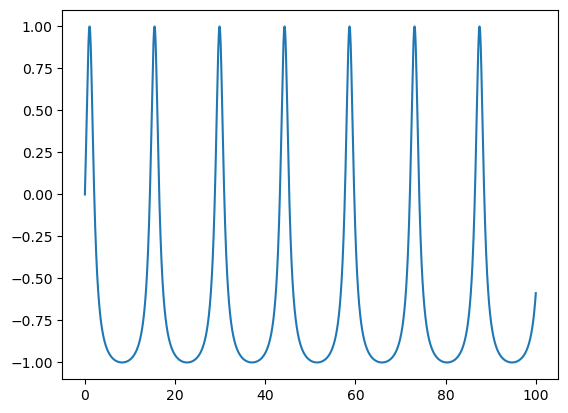

In [9]:
# deterministic
a=1
w=-0.9
simu_time=100
timespan=(0,simu_time)
test=ode.solve_ivp(wsin, timespan, [0], t_eval=np.linspace(0,simu_time,simu_time*100+1), method='RK45', rtol=1e-6, atol=1e-9)
bias=(a-0.5*w)*test.t
plt.figure()
# plt.plot(test.t, test.y[0]-bias)
sin=np.sin(test.y[0])
plt.plot(test.t,sin)

C:\Users\a1596\AppData\Local\Temp\ipykernel_10168\33989755.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dif[0][0]=sigma/(abs(np.cos(x))+0.001)


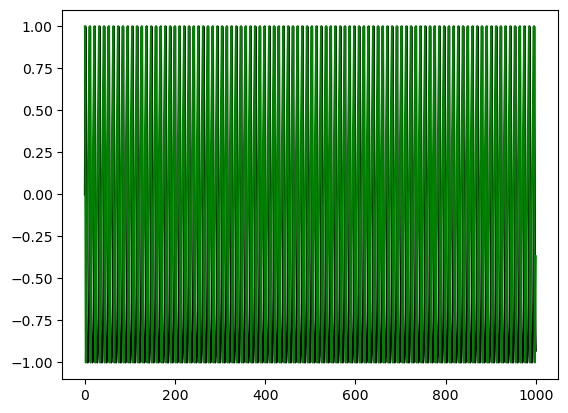

In [10]:
simu_time=10000
timespan=(0,simu_time)
sigma=0.005
repeats=1

a=1
w=-0.8
wspan=[-0.8,-0.4,-0.2,-0.1,0.1,0.2,0.4,0.8]


sinorig=[None]*repeats
sinstochastic=[None]*repeats
cosstochastic=[None]*repeats
original=ode.solve_ivp(wsin, timespan, [0], t_eval=np.linspace(0,simu_time,simu_time*100+1), method='RK45', rtol=1e-6, atol=1e-9)
sinorig=np.sin(original.y[0])
cosorig=np.cos(original.y[0])
for i in range(0,repeats):
    stochastic=sdeint.itoEuler(drift, diffusion, [0], np.linspace(0,simu_time,simu_time*100+1))
    sinstochastic[i]=np.sin(stochastic)
    cosstochastic[i]=np.cos(stochastic)
avgsinstochastic=np.mean(sinstochastic,axis=0)
avgcosstochastic=np.mean(cosstochastic,axis=0)
plt.figure()
plt.plot(original.t[:10*simu_time],sinorig[:10*simu_time],label='original',color='black')
plt.plot(original.t[:10*simu_time],cosorig[:10*simu_time],label='original',color='green')
#plt.plot(original.t[:10*simu_time],avgsinstochastic[:10*simu_time],label='stochastic',color='red')
#plt.plot(original.t[:10*simu_time],avgcosstochastic[:10*simu_time],label='cosine',color='blue')

Next, autocorrelation function is calculated.

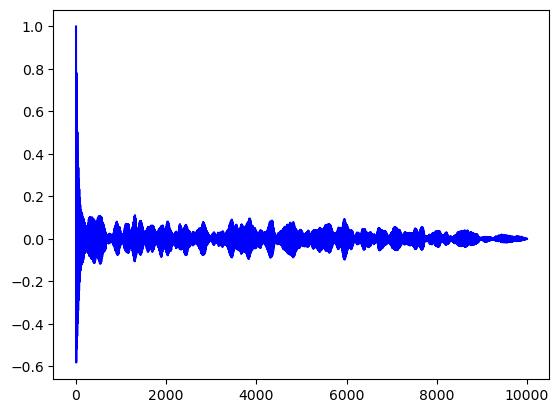

In [11]:
import statsmodels.api as sm
acf_result = sm.tsa.acf(avgsinstochastic, nlags=simu_time*300, fft=True)
plt.plot(original.t[:1+simu_time*300],acf_result,label='acf',color='blue')

Evaluate different w's by ACF decay:

In [12]:
import scipy
from scipy.signal import find_peaks
import statsmodels.api as sm

simu_time=1000
timespan=(0,simu_time)
sigma=0.005
repeats=100

a=1
wspan=[-0.8,-0.4,-0.2,-0.1,0.1,0.2,0.4,0.8]

decay_constants=np.zeros(len(wspan))
periods=np.zeros(len(wspan))
decay_measurements=np.zeros(len(wspan))
small_sin=[None]*len(wspan)
small_cos=[None]*len(wspan)
for j in range(0,len(wspan)):
    
    # simulation
    w=wspan[j]
    sinorig=[None]*repeats
    sinstochastic=[None]*repeats
    original=ode.solve_ivp(wsin, timespan, [0], t_eval=np.linspace(0,simu_time,simu_time*100+1), method='RK45', rtol=1e-6, atol=1e-9) #deterministic
    sinorig=np.sin(original.y[0])
    cosorig=np.cos(original.y[0])
    for i in range(0,repeats):
        stochastic=sdeint.itoEuler(drift, diffusion, [0], np.linspace(0,simu_time,simu_time*100+1))
        sinstochastic[i]=np.sin(stochastic)
    avgsinstochastic=np.mean(sinstochastic,axis=0)
    avgsinstochastic_1d=avgsinstochastic.flatten()
    
    acf_result = sm.tsa.acf(avgsinstochastic, nlags=simu_time*30, fft=True)
    
    # decay regression
    def decay_func(x, b):
        return np.exp(-b * x)
    peaks,_ = find_peaks(acf_result)
    peaks_height = acf_result[peaks]
    peaks=peaks/100
    params, covariance = scipy.optimize.curve_fit(decay_func, peaks, peaks_height,p0=[0.05])
    decay_constants[j]=float(params[0])
    periods[j]=f.find_period(avgsinstochastic_1d)
    for i in range(0,len(decay_constants)):
        decay_measurements[i]=1/(decay_constants[i]*periods[i])
    
    # small value time
    orig_peaks,_=find_peaks(sinorig[:10*simu_time])
    time_start=orig_peaks[0]
    time_end=orig_peaks[1]
    timelength=(time_end-time_start)*100
    sin_effective=1+sinorig[time_start:time_end]
    cos_effective=1+cosorig[time_start:time_end]
    sin_integral=sum(sin_effective)/100
    #sin_threshold=sin_integral/4
    sin_threshold=0.25
    cos_integral=sum(cos_effective)/100
    cos_threshold=0.25
    sin_count=sum(sin_effective<sin_threshold)/timelength
    cos_count=sum(cos_effective<cos_threshold)/timelength
    small_sin[j]=sin_count
    small_cos[j]=cos_count


C:\Users\a1596\AppData\Local\Temp\ipykernel_10168\33989755.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dif[0][0]=sigma/(abs(np.cos(x))+0.001)
C:\Users\a1596\AppData\Local\Temp\ipykernel_10168\3658120634.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  decay_measurements[i]=1/(decay_constants[i]*periods[i])


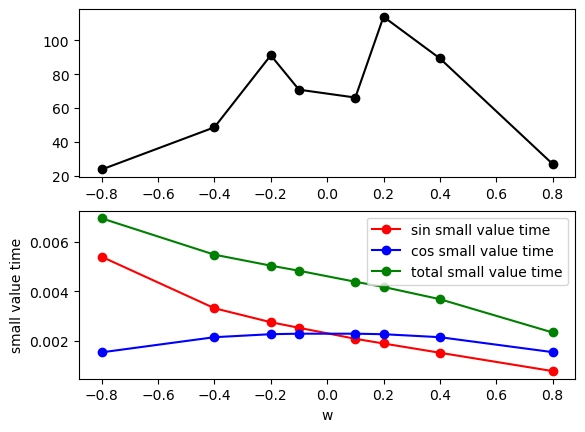

In [13]:
small_tot=[None]*len(wspan)
for i in range(0,len(wspan)):
    small_tot[i]=small_cos[i]+small_sin[i]
# plot
plt.figure()
plt.subplot(2,1,1)
plt.plot(wspan,decay_measurements,'o-',label='decay constant',color='black')
plt.subplot(2,1,2)
plt.plot(wspan,small_sin,'o-',label='sin small value time',color='red')
plt.plot(wspan,small_cos,'o-',label='cos small value time',color='blue')
plt.plot(wspan,small_tot,'o-',label='total small value time',color='green')
plt.legend()
plt.xlabel('w')
plt.ylabel('small value time')
plt.show()
    
    